In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from anchor import utils
from anchor import anchor_tabular
from knac import KNAC
from knac_helpers import caption_clusters, find_centers
import matplotlib.patches as patches
import matplotlib as mlp

In [3]:
import seaborn as sns

In [4]:
def plot_roc(model, dataset, features, target, saveas=None):
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve,auc
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp
    
    n_classes = len(np.unique(dataset[target]))
    
    if hasattr(model ,'decision_function'):
        y_score = model.decision_function(dataset[features])
    else:
        if n_classes < 3:
            y_score = model.predict_proba(dataset[features])[::,1]
        else:
            y_score = model.predict_proba(dataset[features])
    y = label_binarize(dataset[target], classes=np.unique(dataset[target]))


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if n_classes > 2:
            fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        else:
            fpr[i], tpr[i], _ = roc_curve(dataset[target], y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if n_classes > 2:
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = roc_curve(dataset[target], y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2

    fig=plt.figure(figsize=(12,9))
    plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'gold', 'khaki', 'red', 'violet','purple'])
    for i, color in zip(range(n_classes), colors):
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC analysis')
    plt.legend(loc="lower right")
    plt.show()
    if saveas is not None:
        fig.savefig(saveas)

In [5]:
from sklearn.datasets import make_blobs, make_classification, make_circles
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [6]:
random_state = 170

# KDDM exeamples

In [7]:
X1, Y1, centers1 = make_blobs(n_samples=300, n_features=2, cluster_std=1.4, centers=3, random_state=random_state, return_centers=True)

clusterer1 = KMeans(n_clusters=4, random_state=random_state)
E1 = clusterer1.fit_predict(X1)

XX=pd.DataFrame({'x1':X1[:,0],'x2':X1[:,1],'E':E1,'C':Y1})
df1 = XX.pivot_table(index='E',columns='C',values='x1',aggfunc='count').fillna(0) #prepareDf2(E1, Y1)

knac1 = KNAC()
knac1.fit(df1)

In [8]:
X2, Y2, centers2 = make_blobs(n_samples=300, n_features=2, cluster_std=1.2, centers=3, random_state=random_state, return_centers=True)

clusterer2 = KMeans(n_clusters=2, random_state=random_state)
E2 = clusterer2.fit_predict(X2)

XX2=pd.DataFrame({'x1':X2[:,0],'x2':X2[:,1],'E':E2,'C':Y2})
df2 = XX2.pivot_table(index='E',columns='C',values='x1',aggfunc='count').fillna(0) #prepareDf2(E2, Y2)
knac2 = KNAC()
knac2.fit(df2)

(2.0, 0.0)

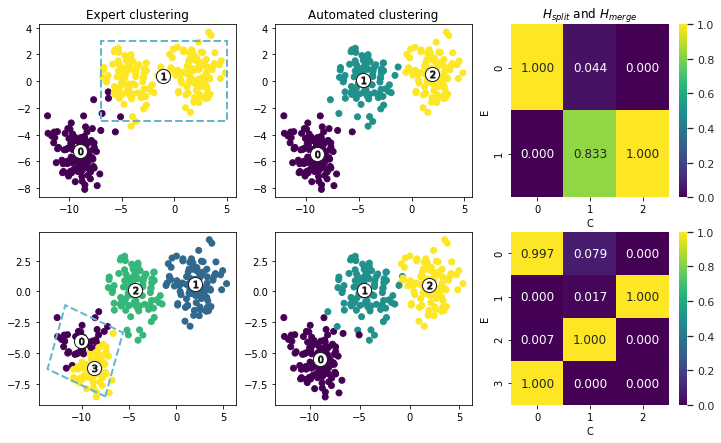

In [9]:
fig,axs = plt.subplots(2,3, figsize=(12,7))
sns.set(font_scale=1)

#merge
sns.heatmap(knac1.H_conf_n, annot=True, cmap='viridis',fmt='.3f',ax=axs[1,2])
axs[1,0].scatter(X1[:,0],X1[:,1], c=E1, cmap='viridis')
axs[1,1].scatter(X1[:,0],X1[:,1], c=Y1, cmap='viridis')
axs[0,0].set(title='Expert clustering')
axs[0,1].set(title='Automated clustering')
axs[0,2].set(title='$H_{split}$ and $H_{merge}$')
axs[1,2].set_ylim([knac1.H_conf_n.shape[0], 0]) # source: https://datascience.stackexchange.com/a/67741

rect = patches.Rectangle((-7.5,-8.5),5.5,6.5,angle=70,ec='c', fc="None", ls='--', linewidth=2, clip_on=False)
axs[1,0].add_patch(rect)
caption_clusters(axs[1,0], find_centers(X1, E1))
caption_clusters(axs[1,1], centers1)

#split
sns.heatmap(knac2.H_conf2, annot=True, cmap='viridis',fmt='.3f',ax=axs[0,2])
axs[0,0].scatter(X2[:,0],X2[:,1], c=E2, cmap='viridis')
axs[0,1].scatter(X2[:,0],X2[:,1], c=Y2, cmap='viridis')
rect = patches.Rectangle((-7,-3),12,6,angle=0,ec='c', fc="None", ls='--', linewidth=2, clip_on=False)
axs[0,0].add_patch(rect)
caption_clusters(axs[0,0], find_centers(X2, E2))
caption_clusters(axs[0,1], centers2)
axs[0,2].set_ylim([knac2.H_conf2.shape[0], 0]) # source: https://datascience.stackexchange.com/a/67741

In [10]:
fig.savefig('synthds-kddm.png')

In [11]:
knac2.splits(threshold_override=0.6, 
            silhouette_metric={
               'weight': 0.1, 
               'data': X1, 
               'labels_automatic': Y1, 
               'labels_expert': E1
            })

E
1    [(1, 2), 0.8692500320357587]
Name: split, dtype: object

In [12]:
knac1.merges(clusters_linkage_metric={
                'weight': 0.2,
                'metric': 'single_link',
                'data': X1, 
                'labels_expert': E1          
            })

,C1,C2,similarity
1,0,3,0.987731


## Explain splits
  * We explain differences between two clusters with complex model, and Anchor
  * We explain splits by building surogate decision tree on the subset containing only these splited data


### Explanation based on complex model and anchor

In [13]:
features=['x1','x2']
target='C'

In [14]:
knac2.splits()

E
1    [(1, 2), 0.916606227946124]
Name: split, dtype: object

### Train classifier on the full data on automated discovered labeling as target

In [15]:
model = xgb.XGBClassifier()

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(XX2[target])

LabelEncoder()

In [17]:
model.fit(XX2[features].values,XX2[target])#le.transform(XX2[target]))

/home/sbk/anaconda3/envs/knac/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
ds = XX2[XX2['E']==1]

In [19]:
centers_anchor = ds.groupby('C').mean()

In [20]:
centers_anchor

,x1,x2,E
C,,,
1,-4.261654,0.194842,1
2,2.037782,0.575308,1


In [21]:
explainerx = anchor_tabular.AnchorTabularExplainer(
    ds.C.to_list(),
    feature_names = centers_anchor[features].columns,
    #train_data=ds[ds['Cluster'].isin([0,5])][features].values,
    train_data = ds[features].values)

In [22]:
idx = 1
model.predict(centers_anchor[features].loc[idx].values.reshape(1,-1))[0]

/home/sbk/anaconda3/envs/knac/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


1

In [23]:
idx = 1
np.random.seed(1)
print('Prediction: ',model.predict(centers_anchor[features].loc[idx].values.reshape(1,-1))[0])
exp = explainerx.explain_instance(centers_anchor[features].loc[idx].values, model.predict, threshold=0.85)

Prediction:  1


In [24]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x1 <= -0.30
Precision: 0.99
Coverage: 0.51


In [25]:
idx = 2 # this is basically cluster 2
np.random.seed(1)
print('Prediction: ', model.predict(centers_anchor[features].loc[idx].values.reshape(1,-1))[0])
exp = explainerx.explain_instance(centers_anchor[features].loc[idx].values, model.predict, threshold=0.95)

Prediction:  2


In [26]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x1 > -0.30
Precision: 1.00
Coverage: 0.49


## Explain with local surogate model
  * Build local model that uses only a portion of data with intersection of expert clusters and clusters suggested for mergining.
  * Two approaches: 
    * Builld local surogate model with minimal depth (decision trunk)
    * Build full tree, and explain it with Anchor

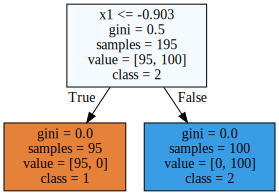

'trunk_split.dot'

In [60]:
from sklearn import tree
from graphviz import Source
from IPython.display import SVG

ds_local = ds.copy()
ds_local = ds_local[ds_local['C'].isin([1,2])]
centers_anchor_local = ds_local.groupby('C').mean()

estimator_local_simple = tree.DecisionTreeClassifier(max_depth=1)
estimator_local = tree.DecisionTreeClassifier(max_depth=3)
estimator_local.fit(ds_local[features], ds_local[target])
estimator_local_simple.fit(ds_local[features], ds_local[target])


graph = Source(tree.export_graphviz(estimator_local_simple, out_file=None
   , feature_names=features, class_names=[str(f) for f in estimator_local_simple.classes_]
   , filled = True))


display(SVG(graph.pipe(format='svg')))
graph.save('trunk_split.dot')

In [58]:
estimator_local_simple.classes_

array([1, 2])

In [56]:
[str(f) for f in ds_local[target].unique()]

['2', '1']

## Simplity local surogate model with Anchor anyway

In [28]:
explainer_local = anchor_tabular.AnchorTabularExplainer(
    ds.C.to_list(),
    feature_names = centers_anchor_local[features].columns,
    train_data=ds_local[features].values,
    categorical_names={})

In [29]:
centers_anchor_local

,x1,x2,E
C,,,
1,-4.261654,0.194842,1
2,2.037782,0.575308,1


In [30]:
idx = 0
np.random.seed(1)
print('Prediction: ', estimator_local.predict(centers_anchor_local[features].iloc[idx].values.reshape(1,-1))[0])
exp = explainer_local.explain_instance(centers_anchor_local[features].iloc[idx].values, estimator_local.predict, threshold=0.95)

Prediction:  1


In [31]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x1 <= -0.30
Precision: 0.99
Coverage: 0.51


In [32]:
idx = 2
np.random.seed(1)
print('Prediction: ', estimator_local.predict(centers_anchor_local[features].loc[idx].values.reshape(1,-1))[0])
exp = explainer_local.explain_instance(centers_anchor_local[features].loc[idx].values, estimator_local.predict, threshold=0.95)

Prediction:  2


In [33]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x1 > -0.30
Precision: 1.00
Coverage: 0.49


## Explain merges
We explain merges in the sam eway as above, but now, decision are expert labels.
We leave the decision if the condition for splitting is sufficient, or is it redundant, or artificial to an expert

In [34]:
target_sur='E'

In [35]:
knac1.merges()

,C1,C2,similarity
1,0,3,0.99846


In [36]:
le_exp = LabelEncoder()
le_exp.fit(XX[target_sur])

LabelEncoder()

## Build full model and explain with Anchor

In [37]:
model_exp = xgb.XGBClassifier()

In [38]:
model_exp.fit(XX[features].values,XX[target_sur])#le_exp.transform(XXm[target_sur]))

[22:04:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/sbk/anaconda3/envs/knac/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
#Moving_right and Moving_left
ds_exp = XX[XX['E'].isin([0,3])]

In [40]:
centers_exp = ds_exp.groupby('E').mean()

In [41]:
centers_exp

,x1,x2,C
E,,,
0,-10.069885,-4.011605,0.052632
3,-8.663468,-6.173419,0.000000


In [42]:
explainer_exp = anchor_tabular.AnchorTabularExplainer(
    le_exp.classes_,
    feature_names = centers_exp[features].columns,
    train_data = XX[features].values,
    categorical_names={})

In [43]:
idx = 0
np.random.seed(1)
print('Prediction: ', model_exp.predict(centers_exp[features].loc[idx].values.reshape(1,-1))[0])
exp = explainer_exp.explain_instance(centers_exp[features].loc[idx].values, model_exp.predict, threshold=0.95)

Prediction:  0


/home/sbk/anaconda3/envs/knac/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [44]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x1 <= -8.20 AND x2 > -4.34
Precision: 1.00
Coverage: 0.07


In [45]:
idx = 3
np.random.seed(1)
print('Prediction: ', model_exp.predict(centers_exp[features].loc[idx].values.reshape(1,-1))[0])
exp = explainer_exp.explain_instance(centers_exp[features].loc[idx].values, model_exp.predict, threshold=0.95)

Prediction:  3


In [46]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: x2 <= -4.34
Precision: 0.90
Coverage: 0.25


# Build local suroage model

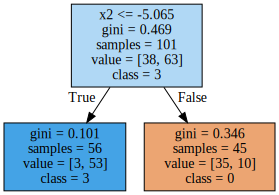

'trunk_merge.dot'

In [62]:
from sklearn import tree
from graphviz import Source
from IPython.display import SVG

centers_anchor_local = ds_exp.groupby('E').mean()

estimator_local_simple_exp = tree.DecisionTreeClassifier(max_depth=1)
estimator_local_exp = tree.DecisionTreeClassifier(max_depth=3)
estimator_local_exp.fit(ds_exp[features], le_exp.transform(ds_exp[target_sur]))
estimator_local_simple_exp.fit(ds_exp[features], le_exp.transform(ds_exp[target_sur]))


graph = Source(tree.export_graphviz(estimator_local_simple_exp, out_file=None
   , feature_names=features, class_names=[str(f) for f in estimator_local_simple_exp.classes_]
   , filled = True))


display(SVG(graph.pipe(format='svg')))
graph.save('trunk_merge.dot')